# 영화리뷰 텍스트 감성분석하기

## 환경설정

In [1]:
!mkdir -p ~/work/sentiment_classification

# 실습에 활용할 수 있도록 라이브러리 설치 및 다운그레이드를 수행합니다
!pip install gensim==4.3.2
!conda install scipy==1.12.0 numpy==1.26.3 -y

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 55.7 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gensim: filename=gensim-4.3.2-cp312-cp312-linux_x86_64.whl size=24072418 sha256=856e9465ca808b3f7492fd17d35aec05736d339c78edb4ecbaf5a315e1f076fa
  Stored in directory: /home/jovyan/.cache/pip/wheels/50/c0/ac/7bb08954bc59d390c848b480a3fc5eec68c14bc77bf334d624
Successfully built gensim
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [gensim]2m2/3 [gensim]
Channels:
 - conda-forge
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 25.5.1
    latest version: 25.11.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - numpy==1.26.3
    - scipy==1.12.0


The following

## 1. 텍스트 데이터 준비

### 1.1 텍스트를 숫자로 표현하기

In [2]:
# 처리해야 할 문장을 파이썬 리스트에 옮겨 담았습니다.
sentences=['i feel hungry', 'i eat lunch', 'now i feel happy']

# 파이썬 split() 메소드를 이용해 단어 단위로 문장을 쪼개 봅니다.
word_list = 'i feel hungry'.split()
print(word_list)

['i', 'feel', 'hungry']


In [3]:
index_to_word={}  # 빈 딕셔너리를 만들어서

# 단어들을 하나씩 채워 봅니다. 채우는 순서는 일단 임의로 하였습니다. 그러나 사실 순서는 중요하지 않습니다.
# <BOS>, <PAD>, <UNK>는 관례적으로 딕셔너리 맨 앞에 넣어줍니다.
index_to_word[0]='<PAD>'  # 패딩용 단어
index_to_word[1]='<BOS>'  # 문장의 시작지점
index_to_word[2]='<UNK>'  # 사전에 없는(Unknown) 단어
index_to_word[3]='i'
index_to_word[4]='feel'
index_to_word[5]='hungry'
index_to_word[6]='eat'
index_to_word[7]='lunch'
index_to_word[8]='now'
index_to_word[9]='happy'

print(index_to_word)

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: 'i', 4: 'feel', 5: 'hungry', 6: 'eat', 7: 'lunch', 8: 'now', 9: 'happy'}


In [4]:
word_to_index={word:index for index, word in index_to_word.items()}
print(word_to_index)

{'<PAD>': 0, '<BOS>': 1, '<UNK>': 2, 'i': 3, 'feel': 4, 'hungry': 5, 'eat': 6, 'lunch': 7, 'now': 8, 'happy': 9}


In [5]:
print(word_to_index['feel'])  # 단어 'feel'은 숫자 인덱스 4로 바뀝니다.

4


In [15]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트로 변환해 주는 함수를 만들어 봅시다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

print('i eat lunch ->', get_encoded_sentence('i eat lunch', word_to_index))

i eat lunch -> [1, 3, 6, 7]


In [7]:
# 여러 개의 문장 리스트를 한꺼번에 숫자 텐서로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# sentences=['i feel hungry', 'i eat lunch', 'now i feel happy'] 가 아래와 같이 변환됩니다.
encoded_sentences = get_encoded_sentences(sentences, word_to_index)
print(encoded_sentences)

[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]]


In [8]:
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

print(get_decoded_sentence([1, 3, 4, 5], index_to_word))

i feel hungry


In [9]:
# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# encoded_sentences=[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 가 아래와 같이 변환됩니다.
print(get_decoded_sentences(encoded_sentences, index_to_word))

['i feel hungry', 'i eat lunch', 'now i feel happy']


### 1.2 Embedding 레이어의 등장

In [10]:
# 아래 코드는 그대로 실행하시면 에러가 발생할 것입니다.

import torch
import torch.nn as nn
import numpy as np
import os

vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4    # 위 그림과 같이 4차원의 워드 벡터를 가정합니다.

embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=word_vector_dim, padding_idx=0)

# 숫자로 변환된 텍스트 데이터 [[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 에 Embedding 레이어를 적용합니다.
raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index), dtype='object')
raw_inputs_tensor = torch.tensor(raw_inputs, dtype=torch.long)
output = embedding(raw_inputs_tensor)
print(output)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [11]:
import torch.nn.functional as F

raw_inputs = [torch.tensor(sentence, dtype=torch.long) for sentence in raw_inputs]
raw_inputs = torch.nn.utils.rnn.pad_sequence(raw_inputs, batch_first=True, padding_value=word_to_index['<PAD>'])
print(raw_inputs)

tensor([[1, 3, 4, 5, 0],
        [1, 3, 6, 7, 0],
        [1, 8, 3, 4, 9]])


In [12]:
vocab_size = len(word_to_index)   # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4   # 그림과 같이 4차원의 워드 벡터를 가정합니다.

embedding = nn.Embedding(vocab_size, word_vector_dim, padding_idx=word_to_index['<PAD>'])

# nn.Embedding를 통해 word vector를 모두 일정 길이로 맞춰주어야
# embedding 레이어의 input이 될 수 있음에 주의해 주세요.
encoded_sentences = get_encoded_sentences(sentences, word_to_index)
maxlen = 5
padded_sentences = [sentence + [word_to_index['<PAD>']] * (maxlen - len(sentence)) if len(sentence) < maxlen else sentence[:maxlen] for sentence in encoded_sentences]

raw_inputs = torch.tensor(padded_sentences, dtype=torch.long)
output = embedding(raw_inputs)
print(output)

tensor([[[ 0.4701,  0.7258,  1.1158,  0.2430],
         [ 1.3515, -0.0219, -0.2576, -1.5837],
         [-0.0396,  0.7881, -0.7346, -1.1333],
         [ 0.6553, -1.3290,  0.5398,  0.6541],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.4701,  0.7258,  1.1158,  0.2430],
         [ 1.3515, -0.0219, -0.2576, -1.5837],
         [ 1.6850, -0.3143,  0.4402,  0.2877],
         [ 1.3576,  0.0432, -0.6407,  0.7821],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.4701,  0.7258,  1.1158,  0.2430],
         [-0.4599,  0.1429, -0.8304,  0.0138],
         [ 1.3515, -0.0219, -0.2576, -1.5837],
         [-0.0396,  0.7881, -0.7346, -1.1333],
         [ 0.2301,  0.0399, -1.9267,  0.8632]]], grad_fn=<EmbeddingBackward0>)


## 2. 시퀀스 데이터를 다루는 모델들 (RNN, ...)

In [17]:
class Model_1(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(Model_1, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.lstm = nn.LSTM(word_vector_dim, 8, batch_first=True)   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
        self.fc1 = nn.Linear(8, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(x)
        x = h_n[-1]
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

vocab_size = 10   # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다.
model = Model_1(vocab_size, word_vector_dim)

print(model)

Model_1(
  (embedding): Embedding(10, 4)
  (lstm): LSTM(4, 8, batch_first=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [18]:
class Model_2(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(Model_2, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.conv1 = nn.Conv1d(word_vector_dim, 16, kernel_size=7)
        self.conv2 = nn.Conv1d(16, 16, kernel_size=7)
        self.pool = nn.MaxPool1d(5)
        self.global_max_pooling = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(16, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.global_max_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

vocab_size = 10    # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다.
model = Model_2(vocab_size, word_vector_dim)

print(model)

Model_2(
  (embedding): Embedding(10, 4)
  (conv1): Conv1d(4, 16, kernel_size=(7,), stride=(1,))
  (conv2): Conv1d(16, 16, kernel_size=(7,), stride=(1,))
  (pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (global_max_pooling): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=16, out_features=8, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [19]:
class Model_3(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(Model_3, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.global_max_pooling = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(word_vector_dim, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.global_max_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

vocab_size = 10   # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다.
model = Model_3(vocab_size, word_vector_dim)

print(model)

Model_3(
  (embedding): Embedding(10, 4)
  (global_max_pooling): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


## 3. IMDB 영화리뷰 감성분석 (영어 VER.)

### 3.1 IMDB 데이터셋 분석

In [21]:
!ln -s /home/jovyan/data /home/jovyan/work/sentiment_classification/

ln: failed to create symbolic link '/home/jovyan/work/sentiment_classification/data': File exists


In [22]:
# 원본 IMDb 데이터셋 다운로드
# import tensorflow as tf
# imdb = tf.keras.datasets.imdb

# (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

# 이번 실습에서는 미리 다운로드된 데이터셋을 불러와 활용하겠습니다
data_dir = os.path.join(os.getenv('HOME') + '/work/sentiment_classification/data/')

x_train = np.load(data_dir + 'imdb_x_train.npy', allow_pickle=True)
y_train = np.load(data_dir + 'imdb_y_train.npy', allow_pickle=True)
x_test = np.load(data_dir + 'imdb_x_test.npy', allow_pickle=True)
y_test = np.load(data_dir + 'imdb_y_test.npy', allow_pickle=True)
print(f"훈련 샘플 개수: {len(x_train)}, 테스트 개수: {len(x_test)}")

훈련 샘플 개수: 25000, 테스트 개수: 25000


In [23]:
print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
라벨:  1
1번째 리뷰 문장 길이:  218
2번째 리뷰 문장 길이:  189


In [24]:
# word_to_index = imdb.get_word_index()
word_to_index = np.load(data_dir + 'imdb_word_to_index.pickle', allow_pickle=True)
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[1])     # 'the' 가 출력됩니다.
print(word_to_index['the'])  # 1 이 출력됩니다.

the
1


In [25]:
# 보정 전 x_train[0] 데이터
print(get_decoded_sentence(x_train[0], index_to_word))

as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room and it so heart shows to years of every never going and help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but and to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other and in of seen over landed for anyone of and br show's to whether from than out themselves history he name half some br of and odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but when from one bit then have two of

In [26]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다.
print(word_to_index['the'])  # 4 이 출력됩니다.
print(index_to_word[4])     # 'the' 가 출력됩니다.

# 보정 후 x_train[0] 데이터
print(get_decoded_sentence(x_train[0], index_to_word))

<BOS>
4
the
this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for

In [27]:
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they h

In [28]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


In [29]:
def pad_sequences(data, maxlen):
    padded_data = []
    for sentence in data:
        if len(sentence) < maxlen:
            sentence = sentence + [0] * (maxlen - len(sentence))
        else:
            sentence = sentence[:maxlen]
        padded_data.append(sentence)
    return np.array(padded_data)

x_train_padded = pad_sequences(x_train, maxlen)
x_test_padded = pad_sequences(x_test, maxlen)

x_train_tensor = torch.tensor(x_train_padded, dtype=torch.long)
x_test_tensor = torch.tensor(x_test_padded, dtype=torch.long)

print(x_train_tensor.shape)

torch.Size([25000, 580])


### 3.2 딥러닝 모델 설계와 훈련

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.lstm = nn.LSTM(word_vector_dim, 8, batch_first=True)
        self.fc1 = nn.Linear(8, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.embedding(x)
        x, (hn, cn) = self.lstm(x)
        x = x[:, -1, :]
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model = SentimentModel(vocab_size, word_vector_dim)
print(model)

SentimentModel(
  (embedding): Embedding(10000, 16)
  (lstm): LSTM(16, 8, batch_first=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)


In [40]:
# validation set 10000건 분리
x_val = x_train_tensor[:10000]
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train_tensor[10000:]
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

torch.Size([15000, 580])
(15000,)


In [41]:
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss()

partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)

x_val_tensor = torch.tensor(x_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float)

train_dataset = TensorDataset(partial_x_train_tensor, partial_y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

epochs = 30   # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)

            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.4f} - "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.4f}")

/tmp/ipykernel_334/1424571675.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
/tmp/ipykernel_334/1424571675.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_tensor = torch.tensor(x_val, dtype=torch.long)


Epoch 1/30 - Train Loss: 0.6941, Train Accuracy: 0.5035 - Validation Loss: 0.6940, Validation Accuracy: 0.4947
Epoch 2/30 - Train Loss: 0.6934, Train Accuracy: 0.5034 - Validation Loss: 0.6935, Validation Accuracy: 0.4948
Epoch 3/30 - Train Loss: 0.6932, Train Accuracy: 0.5033 - Validation Loss: 0.6935, Validation Accuracy: 0.4946
Epoch 4/30 - Train Loss: 0.6932, Train Accuracy: 0.5039 - Validation Loss: 0.6935, Validation Accuracy: 0.4944
Epoch 5/30 - Train Loss: 0.6932, Train Accuracy: 0.5043 - Validation Loss: 0.6936, Validation Accuracy: 0.4942
Epoch 6/30 - Train Loss: 0.6931, Train Accuracy: 0.5049 - Validation Loss: 0.6934, Validation Accuracy: 0.4942
Epoch 7/30 - Train Loss: 0.6930, Train Accuracy: 0.5076 - Validation Loss: 0.6933, Validation Accuracy: 0.4961
Epoch 8/30 - Train Loss: 0.6929, Train Accuracy: 0.5045 - Validation Loss: 0.6934, Validation Accuracy: 0.4965
Epoch 9/30 - Train Loss: 0.6928, Train Accuracy: 0.5094 - Validation Loss: 0.6934, Validation Accuracy: 0.4972
E

In [42]:
test_dataset = TensorDataset(x_test_tensor, torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)

        test_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

Test Loss: 0.7183, Test Accuracy: 0.5030


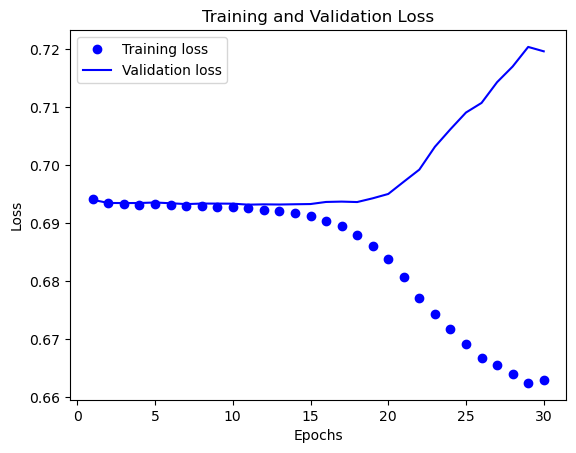

In [43]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs_range, train_losses, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_range, val_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

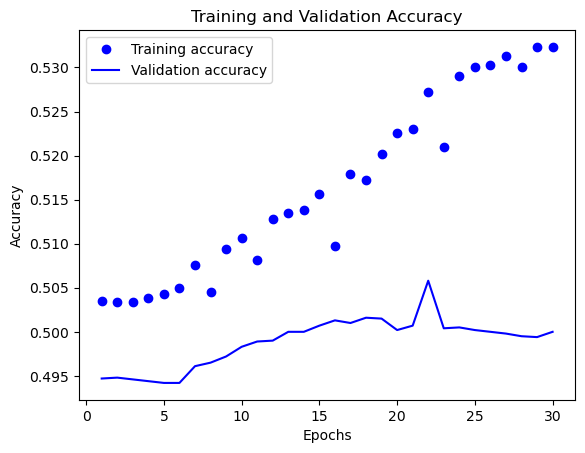

In [44]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs_range, train_accs, 'bo', label='Training accuracy')
plt.plot(epochs_range, val_accs, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 3.3 Word2Vec의 적용

In [46]:
# !mkdir -p sentiment_classification/data
# !pip install gensim==4.3.2
# !pip install scipy==1.12.0 numpy==1.26.3

In [47]:
embedding_layer = model.embedding
weights = embedding_layer.weight.detach().cpu().numpy()

print(weights.shape)  # shape: (vocab_size, embedding_dim)

(10000, 16)


In [48]:
!mkdir ~/work/sentiment_classification/word2vec_emb

mkdir: cannot create directory ‘/home/jovyan/work/sentiment_classification/word2vec_emb’: File exists


In [49]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path = os.path.join(os.getenv('HOME') + '/work/sentiment_classification/word2vec_emb/word2vec.txt')

with open(word2vec_file_path, 'w') as f:
    f.write('{} {}\n'.format(vocab_size - 4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다.
    vectors = model.embedding.weight.detach().cpu().numpy()
    for i in range(4, vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, vectors[i, :]))))

In [50]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

array([-1.080664  ,  0.7333377 ,  0.44427446, -0.5355588 , -0.69131356,
       -1.3676214 ,  0.21014021, -1.322183  ,  0.6057394 ,  1.4558753 ,
       -1.7406282 , -0.9430531 ,  1.096637  ,  1.1716045 , -0.4896162 ,
        0.66357905], dtype=float32)

In [51]:
word_vectors.similar_by_word("love")

[('benoit', 0.8287492990493774),
 ('stubborn', 0.8240334391593933),
 ('lieutenant', 0.732455849647522),
 ('mastermind', 0.7298125624656677),
 ('sort', 0.7277691960334778),
 ('amongst', 0.7179438471794128),
 ('words', 0.7117175459861755),
 ('switch', 0.709032416343689),
 ('enhances', 0.7001492381095886),
 ('fifth', 0.698197066783905)]

In [52]:
from gensim.models import KeyedVectors

word2vec_path = data_dir + 'GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터입니다.

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [53]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("love")

[('loved', 0.6907791495323181),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100708842277527),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547304749488831),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

In [54]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [131]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SentimentModel(nn.Module):
    def __init__(self, vocab_size, word_vector_dim, embedding_matrix, maxlen):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)    # 카피한 임베딩을 여기서 활용
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = True
        self.conv1 = nn.Conv1d(in_channels=word_vector_dim, out_channels=16, kernel_size=7)
        self.pool = nn.MaxPool1d(kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=7)
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(16, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.global_max_pool(x).squeeze(2)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수

embedding_matrix = torch.randn(vocab_size, word_vector_dim)

model = SentimentModel(vocab_size, word_vector_dim, embedding_matrix, maxlen)
print(model)

SentimentModel(
  (embedding): Embedding(10000, 300)
  (conv1): Conv1d(300, 16, kernel_size=(7,), stride=(1,))
  (pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 16, kernel_size=(7,), stride=(1,))
  (global_max_pool): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=16, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)


/tmp/ipykernel_9073/1688845905.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))


In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.BCELoss()

partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)

x_val_tensor = torch.tensor(x_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float)

train_dataset = TensorDataset(partial_x_train_tensor, partial_y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

# 학습의 진행
epochs = 20    # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.
train_losses = []
val_losses = []
train_accs = []
val_accs = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)  # cuda 또는 cpu 출력
model.to(device)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)

            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.4f} - "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.4f}")

In [ ]:
# 테스트셋을 통한 모델 평가
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

x_test_tensor = torch.tensor(x_test_padded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)

        test_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

## 4. 프로젝트: 네이버 영화리뷰 감성분석 도전하기 (한국어 VER.)

### 환경설정

In [ ]:
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
!mv ratings_*.txt ~/work/sentiment_classification/data

--2026-01-30 00:20:08--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘ratings_train.txt’

ratings_train.txt   100%[===================>]  13.95M  47.4MB/s    in 0.3s    

2026-01-30 00:20:10 (47.4 MB/s) - ‘ratings_train.txt’ saved [14628807/14628807]

--2026-01-30 00:20:10--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [application/octet

In [1]:
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab_light_220429.sh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 8.5 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 4.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [konlpy]2m2/3 [konlpy]
fatal: destination path 'Mecab-ko-for-Google-Colab' already exists and is not an empty directory.
/home/jovyan/work/AIFFEL_quest_rs/Exploration/Ex06/Mecab-ko-for-Google-Colab
install_mecab-ko_on_colab_light_220429.sh: line 4: cd: /content: No such file or directory
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2026-01-30 00:23:58--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 13.200.41.134, 13.200.41.135, 13.200.41.136, ...
Connecting to bitbucket.org (bitbucket.org)|13.200.41.134|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2026-01-30

In [6]:
!python --version

Python 3.12.11


In [7]:
!pip install gensim==4.3.2

In [8]:
# 의존성 연결을 위해 다운그레이드를 진행합니다.
!pip install scipy==1.12.0 numpy==1.26.3

In [9]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

2.3.0
0.6.0
4.3.2


### 4.1 데이터 준비와 확인

In [10]:
import pandas as pd
import os

# 데이터를 읽어봅시다.
train_data = pd.read_table(os.getenv("HOME") + '/work/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table(os.getenv("HOME") + '/work/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 4.2 데이터로더 구성

- (미션) imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader 만들기  
    - 데이터의 중복 제거  
    - NaN 결측치 제거  
    - 한국어 토크나이저로 토큰화  
    - 불용어(Stopwords) 제거  
    - 사전 word_to_index 구성  
    - 텍스트 스트링을 사전 인덱스 스트링으로 변환  
    - X_train, y_train, X_test, y_test, word_to_index 리턴  

In [11]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = [
    # 조사, 접속사
    '의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다',
    '고', '지만', '면', '은데', '는데', '하다가', '하면서', '하면서도', '까지', '부터', '같', '듯', '뿐', '라도',
    
    # 자주 쓰이는 동사/형용사 어근
    '있', '없', '되', '보', '했', '해', '나오', '만들', '않', '싶', '봤', '주', '쓰', '알', '되', '되었', '되다', '되나',
    
    # 일반 의미 없는 단어
    '것', '기', '거', '점', '말', '이거', '저', '그', '이런', '다시', '이거', '이건', '저건', '이게', '저게',
    
    # 감탄사, 반복, 이모티콘
    'ㅋㅋ', 'ㅋㅋㅋ', 'ㅎㅎ', 'ㅠ', 'ㅠㅠ', 'ㅠㅠㅠ', 'ㅜ', 'ㅜㅜ', '!', '?', '.', '..', '...', '~', '~~', '-', '—',
    
    # 숫자/순서/단위
    '1', '2', '3', '4', '5', '10', '번', '일', '편', '개', '등', '명', '회', '시', '분', '초',
    
    # 기타 반복 기호 및 특수 문자
    ',', '(', ')', ';', ';;', ':', '"', "'", '“', '”', '…', '·', '/'
]

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) #데이터의 중복 제거
    train_data = train_data.dropna(how = 'any') #NaN 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    # 사전 word_to_index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4) #상위 9996개 단어
    vocab = ['', '', '', ''] + [key for key, _ in counter] #특수 토큰 4개 추
    word_to_index = {word:index for index, word in enumerate(vocab)}

    #텍스트 스트링 → 인덱스 스트링 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist] #없는 단어는 '' 인덱스로 처리

    X_train = list(map(wordlist_to_indexlist, X_train)) #map으로 전체 데이터 변환
    X_test = list(map(wordlist_to_indexlist, X_test))

    #리턴 값 - X_train, y_train, X_test, y_test, word_to_index 모두 반환
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index 

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [12]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [13]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 4.3 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포

In [14]:
# 각 문장의 길이 계산
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(num_tokens) for num_tokens in total_data_text]

# 최소, 최대, 평균 길이
print("문장 길이 최소:", min(num_tokens))
print("문장 길이 최대:", max(num_tokens))
print("문장 길이 평균:", sum(num_tokens)/len(num_tokens))

문장 길이 최소: 0
문장 길이 최대: 115
문장 길이 평균: 11.875723741802712


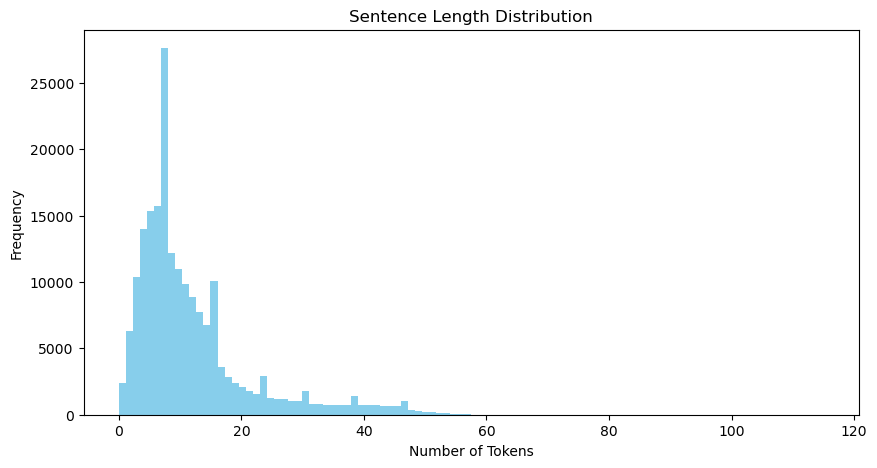

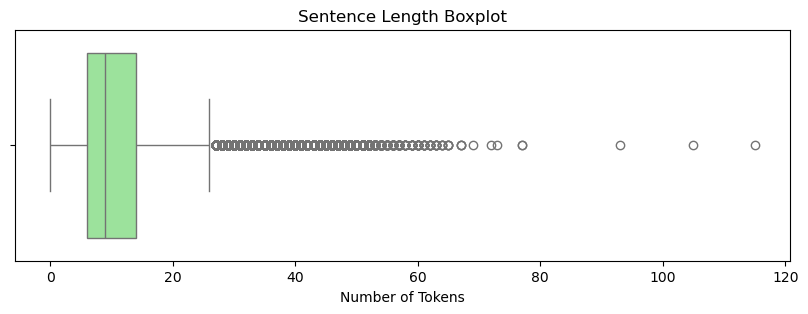

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
plt.hist(num_tokens, bins=100, color='skyblue')
plt.title("Sentence Length Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10,3))
sns.boxplot(x=num_tokens, color='lightgreen')
plt.title("Sentence Length Boxplot")
plt.xlabel("Number of Tokens")
plt.show()


- 적절한 최대 문장 길이 지정

In [69]:
# 최대 길이를 (평균 + 3*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_len = int(max_tokens)
print('pad_sequences max_len : ', max_len)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 max_len 설정값 이내에 포함됩니다. ')

pad_sequences max_len :  31
전체 문장의 0.9357322398496972%가 max_len 설정값 이내에 포함됩니다. 


- torch.nn.utils.rnn.pad_sequence 을 활용한 패딩 추가

In [70]:
import torch
from torch.nn.utils.rnn import pad_sequence

def pad_sequences(data, max_len):
    padded_data = []
    for sentence in data:
        if len(sentence) < max_len:
            sentence = sentence + [0] * (max_len - len(sentence))
        else:
            sentence = sentence[:max_len]
        padded_data.append(sentence)
    return np.array(padded_data)

# 패딩 - 모든 문장을 max_len 길이로 통일
X_train_padded = pad_sequences(X_train, max_len)
X_test_padded = pad_sequences(X_test, max_len)

# tensor로 변환
X_train_tensor = torch.tensor(X_train_padded, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_padded, dtype=torch.long)

print(X_train_tensor.shape) #[문장 수, max_len]

torch.Size([146182, 31])


In [13]:
# Q. 길이 0인 문장 제외하는게 맞을지? 아니면 아무말 없는건 긍정의 의미/부정의 의미인 것 까지도 포함하는게 맞을지?

### 4.4 모델 구성 및 validation set 구성

#### 4.4.1 모델 구성

In [71]:
import torch
import torch.nn as nn
import numpy as np
import os

In [72]:
# Embedding → LSTM → Fully Connected → Sigmoid
class Model_1(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):#, embedding_matrix):
        super(Model_1, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32)) #wor2vec
        self.embedding.weight.requires_grad = True #wor2vec
        self.lstm = nn.LSTM(word_vector_dim, 8, batch_first=True)   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
        self.fc1 = nn.Linear(8, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(x)
        x = h_n[-1]
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


vocab_size = 10000   # 어휘 사전의 크기입니다
word_vector_dim = 100   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 보통 16~128 사이로 선택
lstm = Model_1(vocab_size, word_vector_dim)

#embedding_matrix = torch.randn(vocab_size, word_vector_dim)
#lstm = Model_1(vocab_size, word_vector_dim, embedding_matrix)#, max_len)

print(lstm)

Model_1(
  (embedding): Embedding(10000, 100)
  (lstm): LSTM(100, 8, batch_first=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


/tmp/ipykernel_413/16287955.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32)) #wor2vec


In [73]:
# Embedding → 1D Convolution → MaxPooling → FC → Sigmoid
class Model_2(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(Model_2, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.conv1 = nn.Conv1d(word_vector_dim, 16, kernel_size=7)
        self.conv2 = nn.Conv1d(16, 16, kernel_size=7)
        self.pool = nn.MaxPool1d(5)
        self.global_max_pooling = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(16, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.global_max_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

vocab_size = 10000    # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 100   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다.
cnn = Model_2(vocab_size, word_vector_dim)

#embedding_matrix = torch.randn(vocab_size, word_vector_dim)
#cnn = Model_2(vocab_size, word_vector_dim, embedding_matrix, max_len)

print(cnn)

Model_2(
  (embedding): Embedding(10000, 100)
  (conv1): Conv1d(100, 16, kernel_size=(7,), stride=(1,))
  (conv2): Conv1d(16, 16, kernel_size=(7,), stride=(1,))
  (pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (global_max_pooling): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=16, out_features=8, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [74]:
# Embedding → Global Max Pooling → FC → Sigmoid
class Model_3(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(Model_3, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.global_max_pooling = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(word_vector_dim, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.global_max_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

vocab_size = 10000   # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 100   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다.
gmp = Model_3(vocab_size, word_vector_dim)

#embedding_matrix = torch.randn(vocab_size, word_vector_dim)
#gmp = Model_3(vocab_size, word_vector_dim, embedding_matrix, max_len)

print(gmp)

Model_3(
  (embedding): Embedding(10000, 100)
  (global_max_pooling): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=100, out_features=8, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


#### 4.4.2 validation set 구성

In [83]:
# validation set 10000건 분리
x_val = X_train_tensor[:10000]
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train_tensor[10000:]
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

torch.Size([136182, 31])
(136182,)


### 4.5 모델 훈련 개시

In [84]:
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

#model = lstm

optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss()

partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)

x_val_tensor = torch.tensor(x_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float)

train_dataset = TensorDataset(partial_x_train_tensor, partial_y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

/tmp/ipykernel_413/4270083164.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
/tmp/ipykernel_413/4270083164.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_tensor = torch.tensor(x_val, dtype=torch.long)


In [85]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def train_model(model, train_loader, val_loader, epochs=30, lr=1e-3):
    model = model.to(device)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    for epoch in range(epochs):
        # ----- Train -----
        model.train()
        running_loss, correct, total = 0.0, 0, 0
    
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            optimizer.zero_grad()
    
            outputs = model(inputs).squeeze(1)  # [batch,1] -> [batch]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # ----- Validation -----
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
    
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.float().to(device)
                outputs = model(inputs).squeeze(1)
                loss = criterion(outputs, labels)
    
                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
    
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
    
        print(
            f"[Epoch {epoch+1}] "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

    return history

Using device: cuda


In [86]:
def test_model(model, test_loader):
    model.eval()
    
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.float().to(device)

            outputs = model(inputs).squeeze(1)
            preds = (outputs >= 0.5).float()

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    acc = correct / total
    return acc, torch.cat(all_preds), torch.cat(all_labels)


In [87]:
# Build & Run Models
histories = {}

models_to_run = {
    "lstm": lstm,
    "cnn" : cnn,
    "gmp" : gmp
}

EPOCHS = 30
LR = 0.001

histories = {}
for name, model in models_to_run.items():
    print(f"\n===== Training {name} =====")
    histories[name] = train_model(
        model,
        train_loader,
        val_loader,  
        epochs=EPOCHS,
        lr=LR,
    )


===== Training lstm =====
[Epoch 1] Train Loss: 0.6503, Train Acc: 0.6185 | Val Loss: 0.5621, Val Acc: 0.7269
[Epoch 2] Train Loss: 0.4832, Train Acc: 0.7777 | Val Loss: 0.4418, Val Acc: 0.7984
[Epoch 3] Train Loss: 0.4073, Train Acc: 0.8215 | Val Loss: 0.4100, Val Acc: 0.8167
[Epoch 4] Train Loss: 0.3723, Train Acc: 0.8409 | Val Loss: 0.3974, Val Acc: 0.8230
[Epoch 5] Train Loss: 0.3497, Train Acc: 0.8521 | Val Loss: 0.3912, Val Acc: 0.8267
[Epoch 6] Train Loss: 0.3327, Train Acc: 0.8620 | Val Loss: 0.3898, Val Acc: 0.8274
[Epoch 7] Train Loss: 0.3186, Train Acc: 0.8693 | Val Loss: 0.3920, Val Acc: 0.8278
[Epoch 8] Train Loss: 0.3068, Train Acc: 0.8751 | Val Loss: 0.3903, Val Acc: 0.8295
[Epoch 9] Train Loss: 0.2961, Train Acc: 0.8813 | Val Loss: 0.3945, Val Acc: 0.8300
[Epoch 10] Train Loss: 0.2857, Train Acc: 0.8868 | Val Loss: 0.3987, Val Acc: 0.8293
[Epoch 11] Train Loss: 0.2761, Train Acc: 0.8916 | Val Loss: 0.4012, Val Acc: 0.8295
[Epoch 12] Train Loss: 0.2674, Train Acc: 0.895

RuntimeError: Calculated padded input size per channel: (5). Kernel size: (7). Kernel size can't be greater than actual input size

In [ ]:
test_dataset = TensorDataset(X_test_tensor, torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

test_results = {}

for name, model in models_to_run.items():
    print(f"\n===== Testing {name} =====")
    acc, preds, labels = test_model(model, test_loader)
    
    test_results[name] = {
        "acc": acc,
        "preds": preds,
        "labels": labels
    }

    print(f"{name} Test Accuracy: {acc:.4f}")


### 4.6 Loss, Accuracy 그래프 시각화

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, (name, history) in zip(axes, histories.items()):
    epochs = range(1, len(history["train_loss"]) + 1)

    # Train: 점선
    ax.plot(
        epochs,
        history["train_loss"],
        linestyle="--",
        label="Train Loss"
    )

    # Validation: 실선
    ax.plot(
        epochs,
        history["val_loss"],
        linestyle="-",
        label="Validation Loss"
    )

    ax.set_title(f"{name.upper()} Training & Validation Loss")
    ax.set_xlabel("Epochs")
    ax.grid(True)
    ax.legend()

axes[0].set_ylabel("Loss")

plt.tight_layout()
plt.show()


- 1. 97% 데이터 포함+기본     
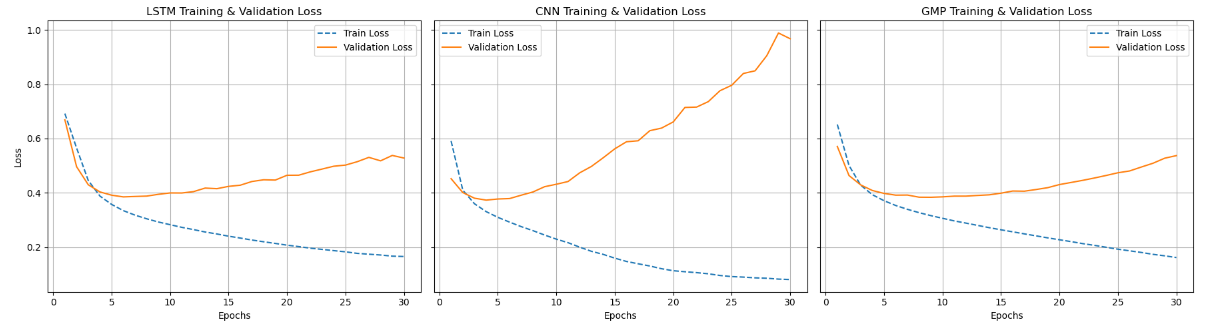  
- 2. 97% 데이터 포함+word2vec
- 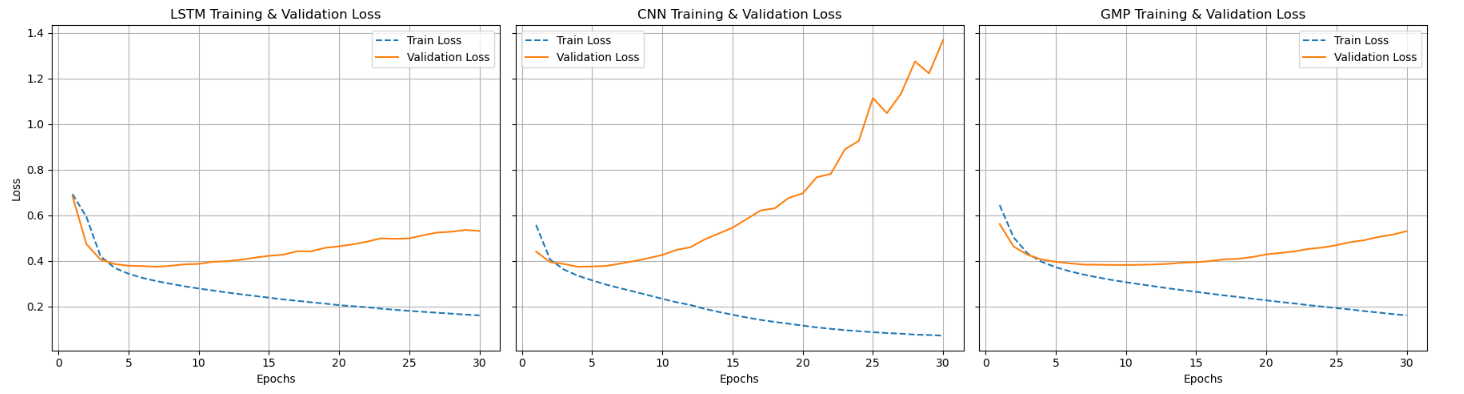

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ----- Training Loss -----
for name, history in histories.items():
    axes[0].plot(
        range(1, len(history["train_loss"]) + 1),
        history["train_loss"],
        label=f"{name} Train"
    )

axes[0].set_title("Training Loss Comparison")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

# ----- Validation Loss -----
for name, history in histories.items():
    axes[1].plot(
        range(1, len(history["val_loss"]) + 1),
        history["val_loss"],
        label=f"{name} Val"
    )

axes[1].set_title("Validation Loss Comparison")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


- 1. 97% 데이터 포함+기본     
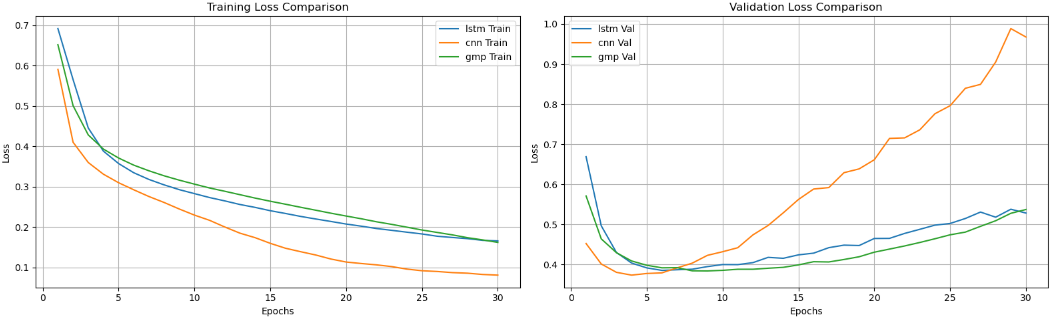  
- validation loss가 5epochs이후 증가하는 경향을 보임(과적합)
- 2. 97% 데이터 포함+word2vec
- 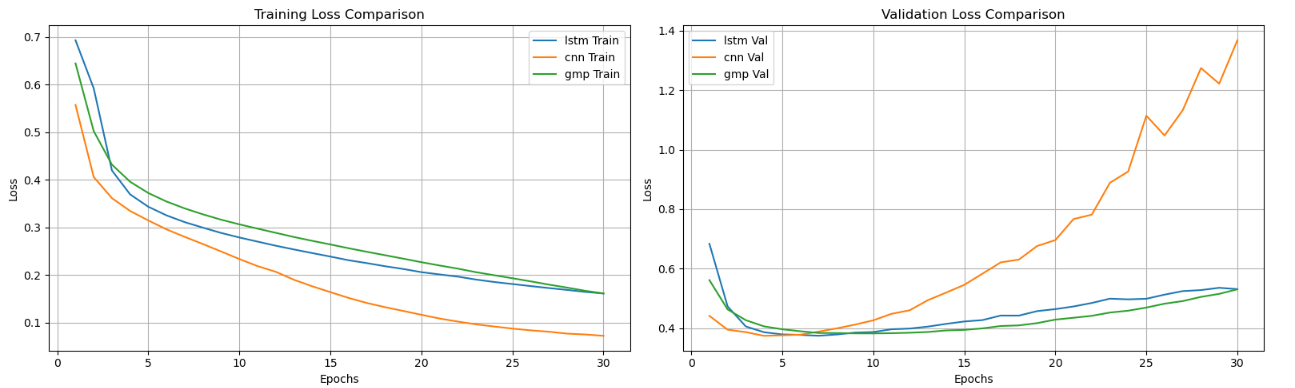

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

names = list(test_results.keys())
accs = [test_results[name]["acc"] for name in names]

plt.figure(figsize=(6,4))
plt.bar(names, accs)
plt.ylim(0,1)
plt.ylabel("Test Accuracy")
plt.title("Model Comparison on Test Set")
plt.show()


name = "lstm"  # 보고 싶은 모델
cm = confusion_matrix(
    test_results[name]["labels"],
    test_results[name]["preds"]
)

disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title(f"{name} Confusion Matrix")
plt.show()


- 정확도 약 80%

### 4.7 학습된 Embedding 레이어 분석

### 4.8 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [76]:
from gensim.models import Word2Vec

# 한국어 Word2Vec 모델 경로
model_path = os.path.join(os.getenv('HOME') + '/data/word2vec_ko.model')

# load() 사용
word2vec_ko = Word2Vec.load(model_path)

In [77]:
vector = word2vec_ko.wv['사랑']  # '사랑' 단어 벡터
print(vector.shape)              # 예: (100,) 등


(100,)


In [78]:
word2vec_ko.wv.most_similar('사랑', topn=10)

[('이별', 0.7626414895057678),
 ('행복', 0.7550068497657776),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167419195175171),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066588997840881),
 ('포옹', 0.7034594416618347),
 ('마음', 0.6972615718841553)]

In [79]:
import torch
import torch.nn as nn

# Word2Vec 단어 벡터 가져오기
vectors = word2vec_ko.wv.vectors  # shape: (vocab_size, embedding_dim)

embedding_matrix = torch.tensor(vectors, dtype=torch.float)

embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
print("Embedding layer ready:", embedding_layer)


Embedding layer ready: Embedding(302960, 100)


In [80]:
# Embedding → LSTM → Fully Connected → Sigmoid
class Model_1(nn.Module):
    def __init__(self, vocab_size, word_vector_dim, embedding_matrix, max_len):
        super(Model_1, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32)) #wor2vec
        self.embedding.weight.requires_grad = True #wor2vec
        self.lstm = nn.LSTM(word_vector_dim, 8, batch_first=True)   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
        self.fc1 = nn.Linear(8, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(x)
        x = h_n[-1]
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


vocab_size = 10000   # 어휘 사전의 크기입니다
word_vector_dim = 100   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 보통 16~128 사이로 선택

embedding_matrix = torch.randn(vocab_size, word_vector_dim)
lstm = Model_1(vocab_size, word_vector_dim, embedding_matrix, max_len)

print(lstm)

Model_1(
  (embedding): Embedding(10000, 100)
  (lstm): LSTM(100, 8, batch_first=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


/tmp/ipykernel_413/3116898112.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32)) #wor2vec


In [81]:
# Embedding → 1D Convolution → MaxPooling → FC → Sigmoid
class Model_2(nn.Module):
    def __init__(self, vocab_size, word_vector_dim, embedding_matrix, max_len):
        super(Model_2, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32)) #wor2vec
        self.embedding.weight.requires_grad = True #wor2vec
        self.conv1 = nn.Conv1d(word_vector_dim, 16, kernel_size=7)
        self.conv2 = nn.Conv1d(16, 16, kernel_size=7)
        self.pool = nn.MaxPool1d(5)
        self.global_max_pooling = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(16, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.global_max_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

vocab_size = 10000    # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 100   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다.
embedding_matrix = torch.randn(vocab_size, word_vector_dim)
cnn = Model_2(vocab_size, word_vector_dim, embedding_matrix, max_len)

print(cnn)

Model_2(
  (embedding): Embedding(10000, 100)
  (conv1): Conv1d(100, 16, kernel_size=(7,), stride=(1,))
  (conv2): Conv1d(16, 16, kernel_size=(7,), stride=(1,))
  (pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (global_max_pooling): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=16, out_features=8, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


/tmp/ipykernel_413/41553756.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32)) #wor2vec


In [82]:
# Embedding → Global Max Pooling → FC → Sigmoid
class Model_3(nn.Module):
    def __init__(self, vocab_size, word_vector_dim, embedding_matrix, max_len):
        super(Model_3, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32)) #wor2vec
        self.embedding.weight.requires_grad = True #wor2vec
        self.global_max_pooling = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(word_vector_dim, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.global_max_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

vocab_size = 10000   # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 100   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다.
embedding_matrix = torch.randn(vocab_size, word_vector_dim)
gmp = Model_3(vocab_size, word_vector_dim, embedding_matrix, max_len)

print(gmp)

Model_3(
  (embedding): Embedding(10000, 100)
  (global_max_pooling): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=100, out_features=8, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


/tmp/ipykernel_413/3485610210.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32)) #wor2vec


회고  
- 85% 정확도로 올리기가 어렵다 ...